---
# Paro Municipios España
---

##### **Alessio Crisafulli Carpani & Davide Bittelli**

![](logo.png)



## Base de datos

Los datos están suministrados por el **SEPE** (Servicio Público de Empleo Estatal) entre los años 2008 y 2014. 

La tabla no se encuentra *normalizada*, por eso hemos modificado el esquema, así como eliminar redundancias de informaciónes.

Hemos utilizado *Vertabelo* para la modelización. Este visual database modeler proporciona la estructura en formato SQL:


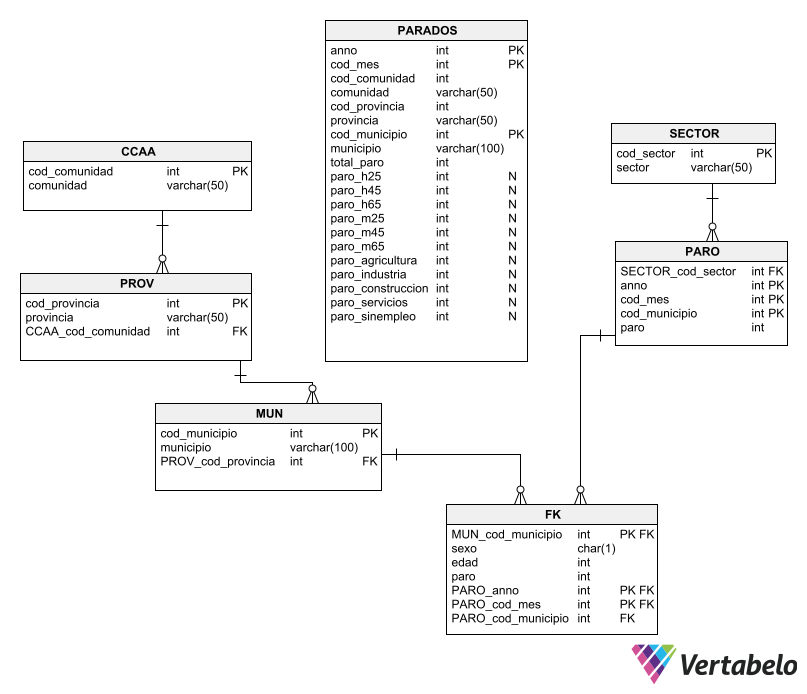

## Migración a IBM Db2

Con **SQL** hemos migrado la información del Sepe en tablas que forman el nuevo esquema. De esta manera, nos hemos agilizado el obtenimiento de las informaciones de nuestro interes, gracias a la definición de claves primarias.

Para desarrollar la arquitectura del database hemos utilizado el sistema de gestión de base de datos **DB2** de IBM.

![img1](db1.png)

Este software nos permite de crear una base de datos a partir de codigos **SQL**

![img1](db2.png)

## Vistas

A partir del database que hemos desarrollado hemos conseguidos unas vistas:

- **Desempleo por sexo y edad;**
- **Desempleo por Comunidades Autónomas y provincias;**
- **Desempleo por tramos de edad;**
- **Desempleo por sexos;**
- **Desempleo por sectores productivos.**

# Accediendo en IBM Db2 database con Python

Una vez finalizada la construcción de nuestra base de datos, hemos construido un entorno en lenguaje **Python** para sacar visualizaciones y adelantar unas analisis 

## Setup

In [ ]:
import ibm_db
import ibm_db_sa

In [ ]:
#Credential setup for database access 
dsn_hostname = "ea286ace-86c7-4d5b-8580-3fbfa46b1c66.bs2io90l08kqb1od8lcg.databases.appdomain.cloud"
dsn_uid = "dbw18884"                 # <-- USUARUO
dsn_pwd = "ixR3YslILOhaB9AP"         # <-- PASSWORD
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"               # e.g. "BLUDB"
dsn_port = "31505"                   # e.g. "50000"
dsn_protocol = "TCPIP"               # i.e. "TCPIP"

dsn = ("DRIVER={0};" "DATABASE={1};""HOSTNAME={2};""PORT={3};""PROTOCOL={4};""UID={5};""PWD={6};SECURITY=SSL").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)


In [ ]:
try:
  conn = ibm_db.connect(dsn, "", "")
  print ("Connected to database: ",dsn_database,"as user: ",dsn_uid,"on host: ",dsn_hostname)
except:
  print ("Unable to connect: ", ibm_db.conn_errormsg() )

Connected to database:  BLUDB as user:  dbw18884 on host:  ea286ace-86c7-4d5b-8580-3fbfa46b1c66.bs2io90l08kqb1od8lcg.databases.appdomain.cloud


# Manipulacíon de datos con Python


In [ ]:
#Import file in Pands dataframe 
import pandas as pd
import ibm_db_dbi

pconn = ibm_db_dbi.Connection(conn)
prov = pd.read_sql("select * from PROV", pconn)
prov.head()

,COD_PROVINCIA,PROVINCIA,CCAA_COD_COMUNIDAD
0,1,Araba/Álava,16
1,2,Albacete,8
2,3,Alicante/Alacant,10
3,4,Almería,1
4,5,Ávila,7


In [ ]:
parados = pd.read_sql("select * from PARADOS", pconn)
parados.to_csv("parados.csv")
parados.columns = parados.columns.str.title()

In [ ]:
#clean column names
parados.columns = parados.columns.str.title()

# creamos columna date para que tenga la fetcha completa
parados['Fecha'] = pd.to_datetime(parados.Anno.astype(str) + '/' + parados.Cod_Mes.astype(str) + '/01')

# extraemos las columnas anno y codigo mes y ponemos la fetcha como index
parados = parados.set_index("Fecha").drop(columns=["Anno"])

#delete redundant informations
parados = parados.drop(parados.filter(regex='Cod_').columns, axis=1)

# Analisis de datos

## Total Paro por Comunidad Autonoma

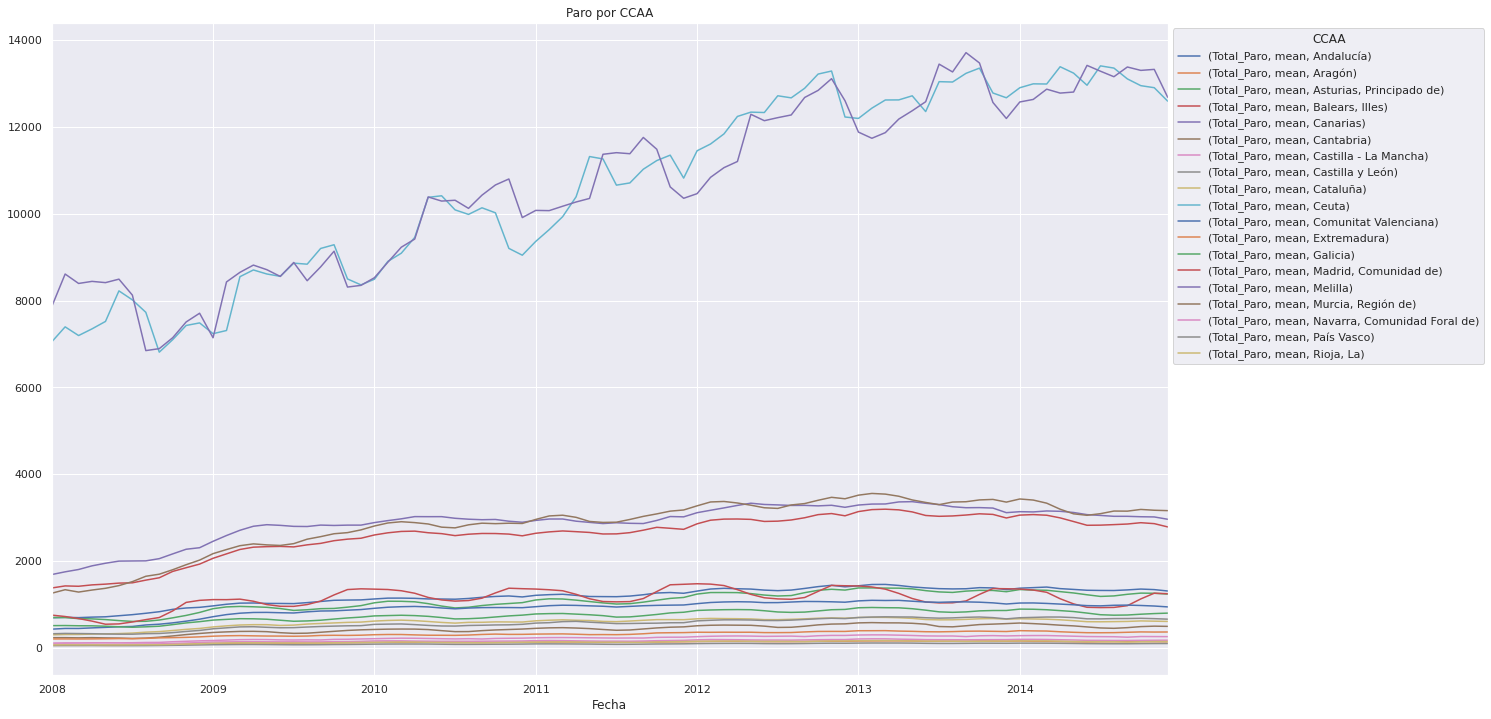

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

p_pccaa = parados.groupby(['Comunidad','Fecha'], as_index=True).agg({'Total_Paro': ['sum']}).unstack(level=0)
ax = p_pccaa.plot(figsize=(20,12), title="Paro por CCAA")
ax.legend(title='CCAA', bbox_to_anchor=(1, 1));

## Mapa de Paro por Provincias


In [ ]:
#Get the information by provincia, #as_index=False and unstack to retirieve vectors
p_prov = parados.groupby(['Provincia'], as_index=False).agg({'Total_Paro': ['mean']}).unstack(level=0)

#retrieve vectors with information as pd.Series
prov = pd.Series(p_prov['Provincia'][''])
mean = pd.Series(p_prov['Total_Paro']['mean'])

#create the dataframe with the information saved in a more feasible way
p_prov = pd.DataFrame({'name': prov,'Avg': mean})

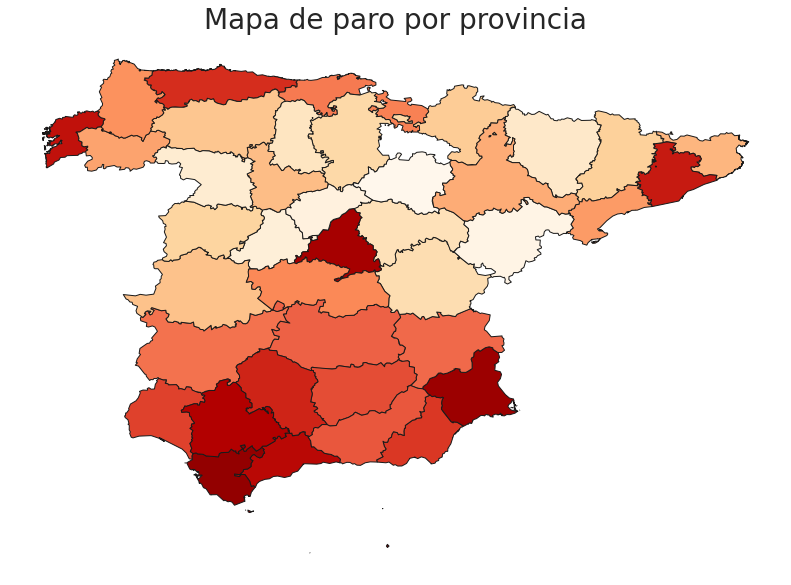

In [ ]:
import geojson
import requests
import geopandas as gpd

data = gpd.GeoDataFrame.from_features(geojson.loads(requests.get('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-provinces.geojson').content))
data = data[['geometry', 'name']].merge(p_prov, on='name')

ax = data.plot(column="Avg", cmap="OrRd", legend=False, figsize=(55,10), edgecolor='k').axis('off');
plt.title("Mapa de paro por provincia", fontsize=28);


## Paro por sexo y edad

In [ ]:
p_SE = pd.read_sql("select * from PARO_SE", pconn)
p_SE.head(), p_SE['SEXO'].unique()

(   ANNO  COD_MES EDAD SEXO  PARO  COD_MUNICIPIO
 0  2008        1   25    M     1           1001
 1  2008        3   25    M     1           1001
 2  2008        1   25    H     2           1001
 3  2008        4   25    M     2           1001
 4  2011        9   25    H     2           1001,
 array(['M', 'H'], dtype=object))

In [ ]:
p_SE.groupby(['SEXO','EDAD']).agg({'PARO':'mean'}).unstack(level=0).round(2)

PARO        
SEXO       H       M
EDAD                
25     28.63   23.89
45    126.01  135.34
65     92.03   98.22

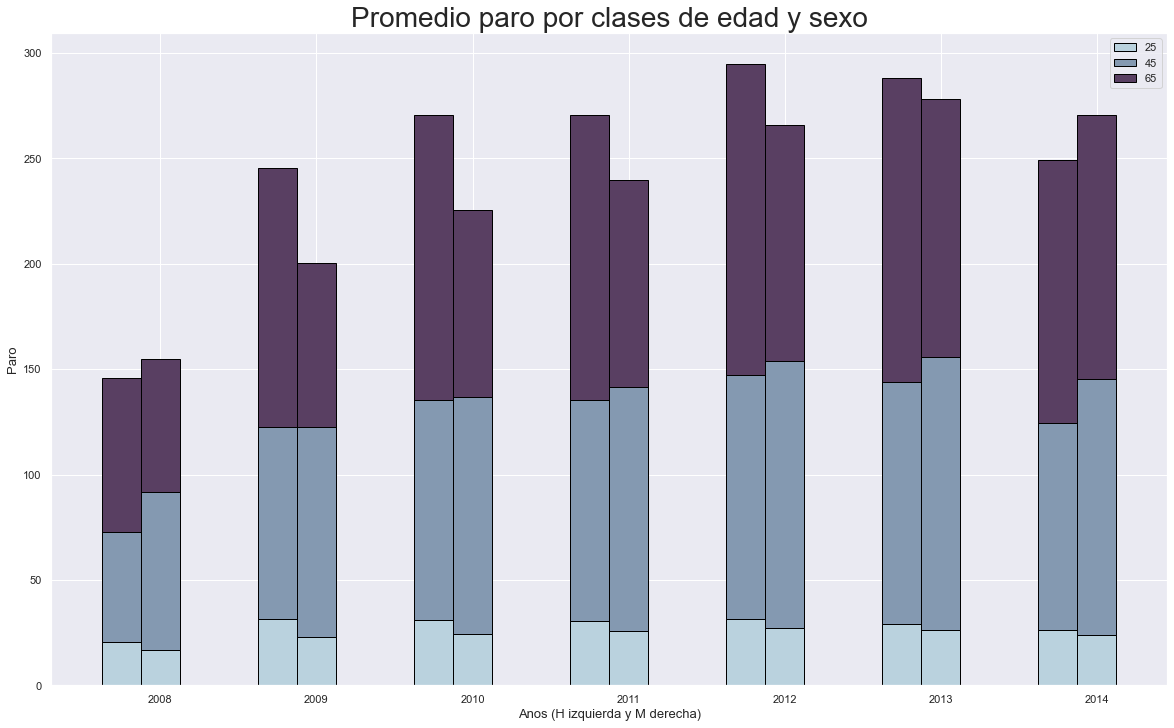

In [9]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 7
ind = np.arange(N) 
width = 0.25
plt.figure(figsize=(20,12))

H25 = [20.749979 ,31.423586 ,31.185413 ,30.509569 ,31.270615 ,28.940413 ,26.338908]
H45 = [72.918361 ,122.748737 ,135.280450 ,135.312180 ,147.361340 ,143.937323 ,124.509117]
H65 = [47.633290 ,71.636873 ,83.685588 ,93.300199 ,109.863425 ,119.801363 ,118.323354]

bar25 = plt.bar(ind, H25, width, edgecolor='black', color = '#BAD2DE')
bar45 = plt.bar(ind, H45, width, edgecolor='black', bottom = H25, color = '#8499B1')
bar65 = plt.bar(ind, H45, width, edgecolor='black', bottom = H45, color = '#593F62')



M25 = [16.781960 ,22.900692 ,24.555881 ,25.581374 ,27.306384 ,26.017412 ,24.077830]
M45 = [91.564422 ,122.499795 ,136.634471 ,141.739605 ,153.948667 ,155.789341 ,145.178227]
M65 = [63.268192 ,77.729724 ,88.936122 ,98.040328 ,111.794978 ,122.446768 ,125.298797]

bar25 = plt.bar(ind+width, M25, width, edgecolor='black', color = '#BAD2DE')
bar45 = plt.bar(ind+width, M45, width, edgecolor='black', bottom = M25, color = '#8499B1')
bar65 = plt.bar(ind+width, M65, width, edgecolor='black', bottom = M45, color = '#593F62')

  
plt.xlabel("Anos (H izquierda y M derecha)",size=13)
plt.ylabel('Paro', size=13)
plt.title("Promedio paro por clases de edad y sexo", fontsize=28)
  
plt.xticks(ind+width,['2008', '2009', '2010','2011','2012','2013','2014'])
plt.legend( (bar25, bar45, bar65), ('25', '45', '65') )
plt.show()

## Tasa de Crecimiento Paro por CCAA y sector

In [ ]:
#Hemos creado una vista con ANNO Y los datos de paro por sector
sector = pd.read_sql('select * from SECTOR_ANNO', pconn)
sector.head()

pivot = pd.pivot_table(data=sector, columns='ANNO', values=['PARO_AGRICULTURA','PARO_INDUSTRIA','PARO_CONSTRUCCION','PARO_SERVICIOS','PARO_SINEMPLEO'])
pivot.head()

#Modificamos la tabla pivot subtituyendo en cada ano la tasa de crecimiento referida a el ano pasado
i=2008
for i in range(2008,2014):
    pivot[i] = (((pivot[i+1]-pivot[i])/pivot[i])*100).round(2)
    i=i+1
    
#Cambiamos los nombres de las columnas
del pivot[2014]
pivot = pivot.rename(columns={pivot.columns[0]: '2009', pivot.columns[1]: '2010', pivot.columns[2]: '2011', pivot.columns[3]: '2012', pivot.columns[4]: '2013', pivot.columns[5]: '2014'})

In [10]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns.set()
plt.figure(figsize=(20,12))

ax = pivot.T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("GnBu",10)), figsize=(17,9));
plt.title('Incremento en porcentaje de paro por sector', fontsize=28)
plt.xlabel('');
plt.legend(labels=["Agricultura","Construccion","Industria","Servicios","Sinempleo"], title = "Sectores",
          fontsize = 'large', title_fontsize = "20",
          loc = 2, bbox_to_anchor = (1,1))
plt.xticks(rotation=0, size=0)
yticks=[-25,0,25,50,75,100,125,150,175]
porj=['-25%','0%','25%','50%','75%','100%','125%','150%','175%']
plt.yticks(yticks, labels = porj, size=13)

# Plot stacked bar chart
import numpy as np
table = np.array([pivot.reset_index()['2009'].to_list(),pivot.reset_index()['2010'].to_list(),pivot.reset_index()['2011'].to_list(),pivot.reset_index()['2012'].to_list(),pivot.reset_index()['2013'].to_list(), pivot.reset_index()['2014'].to_list(),])

tabla = plt.table(cellText=table.T,
                 rowLabels=pivot.reset_index()['index'].to_list(),
                 colLabels=[2009,2010,2011,2012,2013,2014],
                 rowColours=sns.color_palette("GnBu",10),
                 loc=17)

tabla.auto_set_font_size(False)
tabla.set_fontsize(15)
tabla.scale(1, 2)

NameError: name 'pivot' is not defined

<Figure size 1440x864 with 0 Axes>

# Analísis de correlación


In [24]:
hogar = pd.read_csv("/content/drive/MyDrive/UCM/Base de Datos/Trabajo Paro/datos/Hogar2008_2014.csv", sep=';', index_col='ANNO')
ecoicop  = pd.read_csv("/content/drive/MyDrive/UCM/Base de Datos/Trabajo Paro/datos/IndiceECOICOP2008_2014.csv", sep=';', index_col='ANNO')
pib = pd.read_csv("/content/drive/MyDrive/UCM/Base de Datos/Trabajo Paro/datos/PIB2008_2014.csv", sep=';', index_col='ANNO')
inversiones = pd.read_csv("/content/drive/MyDrive/UCM/Base de Datos/Trabajo Paro/datos/inversiones2008_2014.csv", sep=';', index_col='ANNO')
parados = pd.read_csv("parados.csv")

merge1 = pd.merge(hogar, ecoicop, on="ANNO")
merge2 = pd.merge(pib, inversiones, on="ANNO")
merge = pd.merge(merge1, merge2, on="ANNO")

,Renta neta media por hogar (eur),Indice general ECOICOP,PIB Espana (miles de euros),Flujos Inversion Bruta en miles de euros
ANNO,,,,
2008,28.787,86.345,1109541000,38587206.56
2009,30.045,87.031,1069323000,20493583.38
2010,29.634,89.631,1072709000,31262147.32
2011,28.206,91.762,1063763000,33952001.38
2012,27.747,94.394,1031099000,18266481.04
2013,26.775,94.632,1020348000,26220952.14
2014,26.154,93.646,1032158000,32180036.38


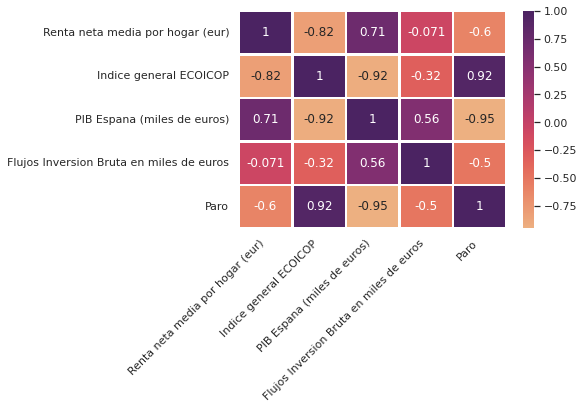

In [25]:
c = parados.groupby('ANNO').agg(Paro=('TOTAL_PARO', 'mean'))*1000
corr = pd.merge(merge, c, on="ANNO").corr()

ax = sns.heatmap(
    corr, annot=True,
    cmap='flare', linewidths=1.5)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');